In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 19, 12
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import collections
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn import metrics, cross_validation

import codecs

C:\Users\takes\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_directory = 'C://Users//takes//GitHub//kaggle//data//home_credit'
main_directory = 'C://Users//takes//GitHub//kaggle//home_credit'

In [3]:
os.chdir(data_directory)
data_train = pd.read_csv('application_train.csv')
data_test = pd.read_csv('application_test.csv')
data_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#with codecs.open('HomeCredit_columns_description.csv', 'r', 'utf-8', 'ignore') as f:
#    column_details = pd.read_csv(f)

### TARGET
Considering this rate, we probably need to reduce negative data by using down sampling.

(array([282686.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  24825.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

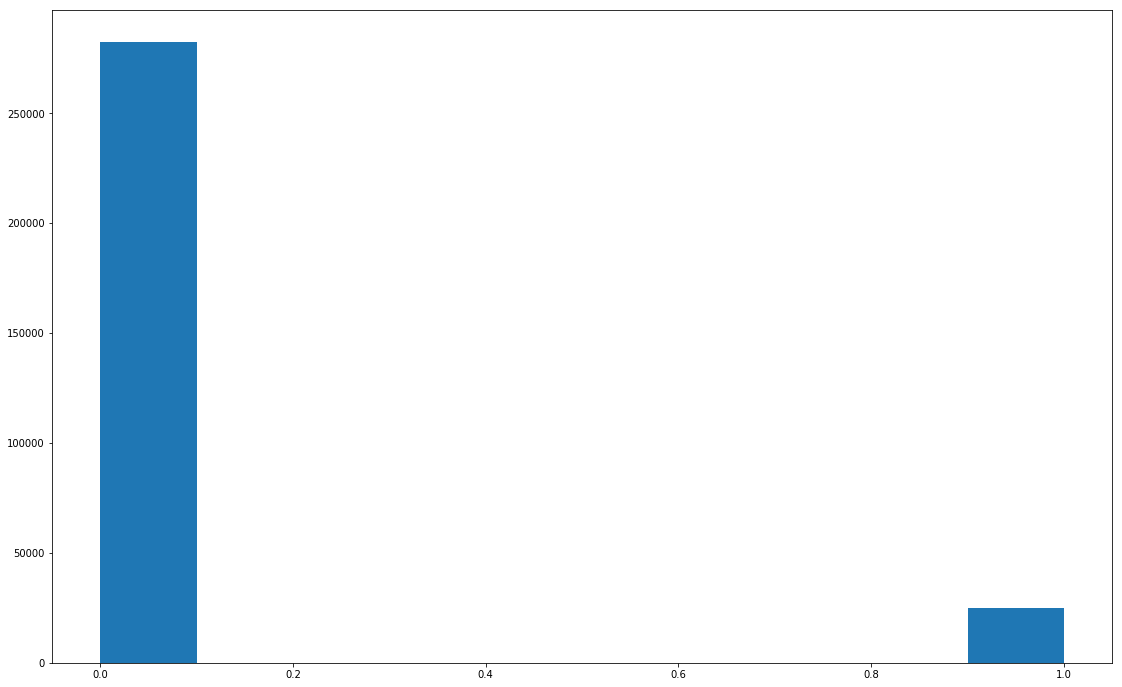

In [6]:
plt.hist(data_train.TARGET)

In [7]:
data_train.iloc[:,:60].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 60 columns):
SK_ID_CURR                     307511 non-null int64
TARGET                         307511 non-null int64
NAME_CONTRACT_TYPE             307511 non-null object
CODE_GENDER                    307511 non-null object
FLAG_OWN_CAR                   307511 non-null object
FLAG_OWN_REALTY                307511 non-null object
CNT_CHILDREN                   307511 non-null int64
AMT_INCOME_TOTAL               307511 non-null float64
AMT_CREDIT                     307511 non-null float64
AMT_ANNUITY                    307499 non-null float64
AMT_GOODS_PRICE                307233 non-null float64
NAME_TYPE_SUITE                306219 non-null object
NAME_INCOME_TYPE               307511 non-null object
NAME_EDUCATION_TYPE            307511 non-null object
NAME_FAMILY_STATUS             307511 non-null object
NAME_HOUSING_TYPE              307511 non-null object
REGION_POPULATION_RELATI

In [8]:
data_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

## Strategy of prediction.

### Model
We use LightGBM can handle nan data, because of many columns contains a lot of nan data.

### Preprocess.
Since one hot encoding has possibility of loss of order structure, we try to convert categorical data to numeric data with order.  

If the column has two element in data, we apply one hot encoding with drop=True.
Else, we try to estimate order structure of the column and convert it. 

### NAME_CONTRACT_TYPE
It contains two paterns. We apply onehot encoding with drop=True. 

In [9]:
collections.Counter(data_train['NAME_CONTRACT_TYPE'])

Counter({'Cash loans': 278232, 'Revolving loans': 29279})

### CODE_GENDER


In [10]:
collections.Counter(data_train['CODE_GENDER'])

Counter({'F': 202448, 'M': 105059, 'XNA': 4})

### FLAG_OWN_CAR

In [11]:
collections.Counter(data_train['FLAG_OWN_CAR'])

Counter({'N': 202924, 'Y': 104587})

### FLAG_OWN_REALTY

In [12]:
collections.Counter(data_train['FLAG_OWN_REALTY'])

Counter({'N': 94199, 'Y': 213312})

In [13]:
i = 1
for col in data_train.columns:
    if data_train.dtypes[col] == 'O':
        print(i)
        print(col)
        print(collections.Counter(data_train[col]))
        print('Length', len(collections.Counter(data_train[col]).keys()))
        print('--------')
        i = i + 1

1
NAME_CONTRACT_TYPE
Counter({'Cash loans': 278232, 'Revolving loans': 29279})
Length 2
--------
2
CODE_GENDER
Counter({'F': 202448, 'M': 105059, 'XNA': 4})
Length 3
--------
3
FLAG_OWN_CAR
Counter({'N': 202924, 'Y': 104587})
Length 2
--------
4
FLAG_OWN_REALTY
Counter({'Y': 213312, 'N': 94199})
Length 2
--------
5
NAME_TYPE_SUITE
Counter({'Unaccompanied': 248526, 'Family': 40149, 'Spouse, partner': 11370, 'Children': 3267, 'Other_B': 1770, nan: 1292, 'Other_A': 866, 'Group of people': 271})
Length 8
--------
6
NAME_INCOME_TYPE
Counter({'Working': 158774, 'Commercial associate': 71617, 'Pensioner': 55362, 'State servant': 21703, 'Unemployed': 22, 'Student': 18, 'Businessman': 10, 'Maternity leave': 5})
Length 8
--------
7
NAME_EDUCATION_TYPE
Counter({'Secondary / secondary special': 218391, 'Higher education': 74863, 'Incomplete higher': 10277, 'Lower secondary': 3816, 'Academic degree': 164})
Length 5
--------
8
NAME_FAMILY_STATUS
Counter({'Married': 196432, 'Single / not married': 45

In [14]:
def test_train_collection(data_train, data_test, col_name):
    name = col_name 
    collection_test = collections.Counter(data_test[name])
    collection_train = collections.Counter(data_train[name])
    print('====Test columns====')

    for test_element in collection_test.keys() :
        if test_element in collection_train.keys():
            print(test_element)
            print(collection_train[test_element], collection_test[test_element])
        else:
            print('----Non Exist.----')
            print(test_element)
    print('====Needless train columns====')
    for train_element in collection_train.keys():
        if not(train_element in collection_test.keys()):
            print(train_element)

In [15]:
def category_information(data, col_name):
    name = col_name
    data_train = data.copy()
    collection_data = collections.Counter(data_train[name])
    rate_list = []
    data_list = list(collection_data.keys())
    data_len = [collection_data[k] for k in data_list]
    for element in data_list:
        for_rate = data_train[data_train[name] == element].TARGET
        if len(for_rate) == 0:
            for_rate = data_train[data_train[name].isnull()].TARGET
            rate = for_rate.sum() / len(for_rate)
        else:
            rate = for_rate.sum() / len(for_rate)
        rate_list.append(rate)
    df = pd.DataFrame()
    df['rate'] = rate_list
    df['element'] = [str(key) for key in data_list]
    df['length'] = data_len                                     
    df = df.sort_values('rate', ascending=False).reset_index(drop=True)
    print(name)
    print(df)
    rcParams['figure.figsize'] = 13, 4
    plt.bar(df.element, df.rate)
    plt.ylim(df.rate.min()-df.rate.mean()/10)
    plt.ylabel('rate')
    return df

### NAME_TYPE_SUITE

NAME_TYPE_SUITE
       rate          element  length
0  0.098305          Other_B    1770
1  0.087760          Other_A     866
2  0.084871  Group of people     271
3  0.081830    Unaccompanied  248526
4  0.078716  Spouse, partner   11370
5  0.074946           Family   40149
6  0.073768         Children    3267
7  0.054180              nan    1292


,rate,element,length
0,0.098305,Other_B,1770
1,0.087760,Other_A,866
2,0.084871,Group of people,271
3,0.081830,Unaccompanied,248526
4,0.078716,"Spouse, partner",11370
5,0.074946,Family,40149
6,0.073768,Children,3267
7,0.054180,nan,1292


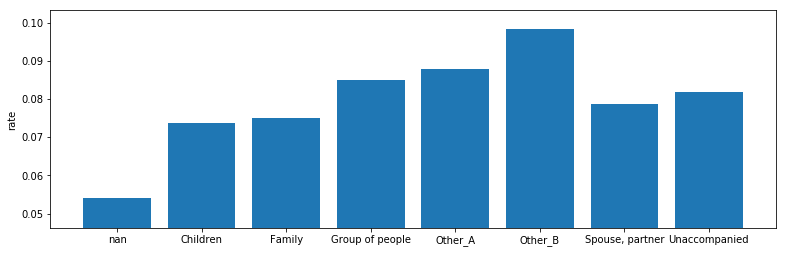

In [16]:
category_information(data_train, 'NAME_TYPE_SUITE')

In [18]:
test_train_collection(data_train, data_test, 'NAME_TYPE_SUITE')

====Test columns====
Unaccompanied
248526 39727
nan
1292 911
Family
40149 5881
Spouse, partner
11370 1448
Group of people
271 49
Other_B
1770 211
Children
3267 408
Other_A
866 109
====Needless train columns====


In [23]:
data_train['NAME_TYPE_SUITE'] = (data_train['NAME_TYPE_SUITE'].replace('Other_B', 3)
                                 .replace('Other_A', 2).replace('Group of people', 2)
                                 .replace('Unaccompanied',2).replace('Spouse, partner',2)
                                 .replace('Family', 1).replace('Children', 1))


### NAME_INCOME_TYPE

NAME_INCOME_TYPE
       rate               element  length
0  0.363636            Unemployed      22
1  0.095885               Working  158774
2  0.074843  Commercial associate   71617
3  0.057550         State servant   21703
4  0.053864             Pensioner   55362
5  0.000000               Student      18
6  0.000000           Businessman      10


,rate,element,length
0,0.363636,Unemployed,22
1,0.095885,Working,158774
2,0.074843,Commercial associate,71617
3,0.057550,State servant,21703
4,0.053864,Pensioner,55362
5,0.000000,Student,18
6,0.000000,Businessman,10


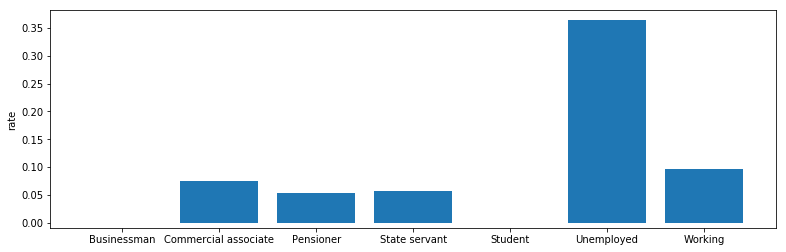

In [28]:
category_information(data_train, 'NAME_INCOME_TYPE')

In [27]:
test_train_collection(data_train, data_test, 'NAME_INCOME_TYPE')

====Test columns====
Working
158774 24533
State servant
21703 3532
Pensioner
55362 9273
Commercial associate
71617 11402
Businessman
10 1
Student
18 2
Unemployed
22 1
====Needless train columns====


In [26]:
data_train = data_train[data_train['NAME_INCOME_TYPE'] != 'Maternity leave']

In [30]:
data_train['NAME_INCOME_TYPE'] = (data_train['NAME_INCOME_TYPE'].replace('Unemployed', 3)
                                  .replace('Working', 2).replace('Commercial associate', 2)
                                  .replace('Pensioner', 1).replace('State servant', 1)
                                  .replace('Student', 0).replace('Businessman', 0))

537913

### NAME_EDUCATION_TYPE

NAME_EDUCATION_TYPE


,rate,element,length
3,0.109277,Lower secondary,3816
0,0.089399,Secondary / secondary special,218391
2,0.084850,Incomplete higher,10277
1,0.053551,Higher education,74863
4,0.018293,Academic degree,164


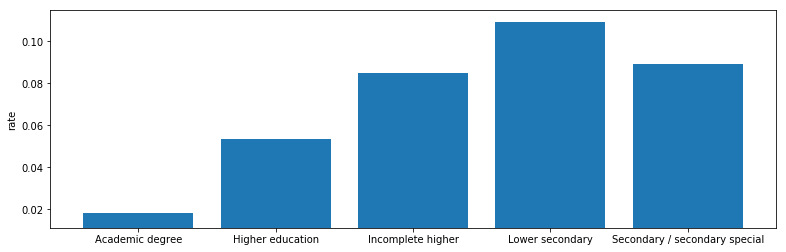

In [166]:
category_information(data_train, 'NAME_EDUCATION_TYPE')

In [167]:
test_train_collection(data_train, data_test, 'NAME_EDUCATION_TYPE')

====Test columns====
Higher education
74863 12516
Secondary / secondary special
218391 33988
Incomplete higher
10277 1724
Lower secondary
3816 475
Academic degree
164 41
====Needless train columns====


In [32]:
data_train['NAME_EDUCATION_TYPE'] = (data_train['NAME_EDUCATION_TYPE'].replace('Lower secondary',3)
                                     .replace('Secondary / secondary special', 2)
                                     .replace('Incomplete higher', 2).replace('Higher education',1)
                                     .replace('Academic degree', 1))

In [34]:
data_train['NAME_EDUCATION_TYPE'].sum()

543804

### NAME_FAMILY_STATUS

NAME_FAMILY_STATUS
       rate               element  length
0  0.099446        Civil marriage   29775
1  0.098077  Single / not married   45444
2  0.081942             Separated   19770
3  0.075590               Married  196427
4  0.058242                 Widow   16088


,rate,element,length
0,0.099446,Civil marriage,29775
1,0.098077,Single / not married,45444
2,0.081942,Separated,19770
3,0.075590,Married,196427
4,0.058242,Widow,16088


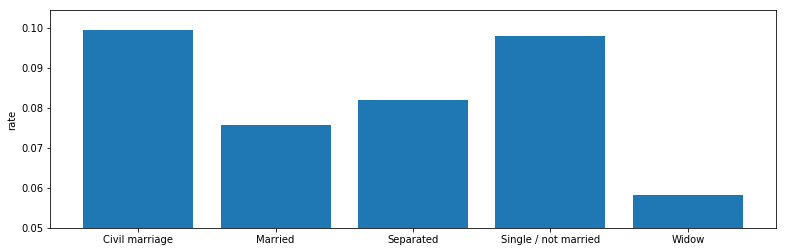

In [37]:
category_information(data_train, 'NAME_FAMILY_STATUS')

In [36]:
test_train_collection(data_train, data_test, 'NAME_FAMILY_STATUS')

====Test columns====
Married
196427 32283
Single / not married
45444 7036
Civil marriage
29775 4261
Widow
16088 2209
Separated
19770 2955
====Needless train columns====


In [35]:
data_train = data_train[data_train['NAME_FAMILY_STATUS'] != 'Unknown']

### NAME_HOUSING_TYPE

NAME_HOUSING_TYPE


,rate,element,length
1,0.123131,Rented apartment,4881
2,0.116981,With parents,14840
3,0.085397,Municipal apartment,11183
5,0.079323,Co-op apartment,1122
0,0.077957,House / apartment,272868
4,0.065724,Office apartment,2617


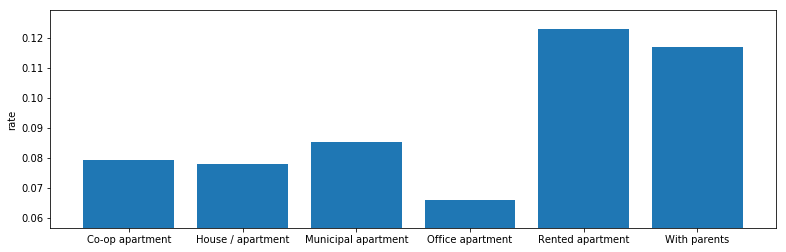

In [108]:
category_information(data_train, 'NAME_HOUSING_TYPE')

In [170]:
test_train_collection(data_train, data_test, 'NAME_HOUSING_TYPE')

====Test columns====
House / apartment
272868 43645
With parents
14840 2234
Rented apartment
4881 718
Municipal apartment
11183 1617
Office apartment
2617 407
Co-op apartment
1122 123
====Needless train columns====


### OCCUPATION_TYPE

OCCUPATION_TYPE


,rate,element,length
14,0.171524,Low-skill Laborers,2093
5,0.113261,Drivers,18603
13,0.112760,Waiters/barmen staff,1348
11,0.107424,Security staff,6721
0,0.105788,Laborers,55186
8,0.104440,Cooking staff,5946
6,0.096318,Sales staff,32102
7,0.096067,Cleaning staff,4653
15,0.078562,Realty agents,751
16,0.070498,Secretaries,1305


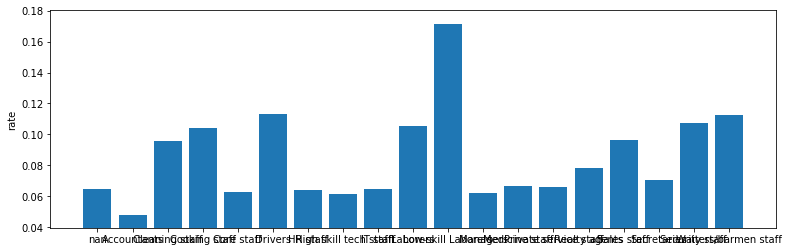

In [109]:
category_information(data_train, 'OCCUPATION_TYPE')

In [171]:
test_train_collection(data_train, data_test, 'OCCUPATION_TYPE')

====Test columns====
nan
96391 15605
Low-skill Laborers
2093 272
Drivers
18603 2773
Sales staff
32102 5072
High skill tech staff
11380 1854
Core staff
27570 4361
Laborers
55186 8655
Managers
21371 3574
Accountants
9813 1628
Medicine staff
8537 1316
Security staff
6721 915
Private service staff
2652 455
Secretaries
1305 213
Cleaning staff
4653 656
Cooking staff
5946 894
HR staff
563 104
Waiters/barmen staff
1348 178
Realty agents
751 138
IT staff
526 81
====Needless train columns====


In [38]:
data_train['OCCUPATION_TYPE'] = (data_train['OCCUPATION_TYPE'].replace('Accountants', 0)
                                 .replace('High skill tech staff', 1).replace('Managers', 1)
                                 .replace('Core staff', 1).replace('HR staff', 1)
                                 .replace('IT staff', 1).replace('Private service staff',2)
                                 .replace('Medicine staff', 2).replace('Secretaries', 2)
                                 .replace('Realty agents', 3).replace('Cleaning staff', 4)
                                 .replace('Sales staff', 4).replace('Cooking staff', 4)
                                 .replace('Laborers', 4).replace('Security staff', 4)
                                 .replace('Waiters/barmen staff', 5).replace('Drivers', 5)
                                 .replace('Low-skill Laborers', 6))

In [39]:
data_train['OCCUPATION_TYPE'].sum()

619389.0

### WEEKDAY_APPR_PROCESS_START

WEEKDAY_APPR_PROCESS_START


,rate,element,length
6,0.083505,TUESDAY,53901
0,0.081604,WEDNESDAY,51934
5,0.081469,FRIDAY,50338
2,0.081003,THURSDAY,50591
3,0.079291,SUNDAY,16181
4,0.078873,SATURDAY,33852
1,0.077572,MONDAY,50714


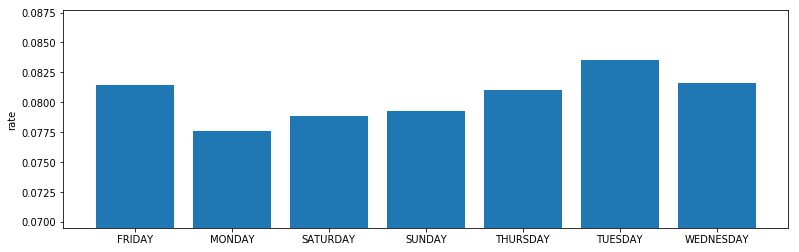

In [110]:
category_information(data_train, 'WEEKDAY_APPR_PROCESS_START')

In [172]:
test_train_collection(data_train, data_test, 'WEEKDAY_APPR_PROCESS_START')

====Test columns====
TUESDAY
53901 9751
FRIDAY
50338 7250
MONDAY
50714 8406
WEDNESDAY
51934 8457
THURSDAY
50591 8418
SATURDAY
33852 4603
SUNDAY
16181 1859
====Needless train columns====


### ORGANIZATION_TYPE

ORGANIZATION_TYPE
        rate                 element  length
0   0.157540       Transport: type 3    1187
1   0.134328       Industry: type 13      67
2   0.125000        Industry: type 8      24
3   0.117062              Restaurant    1811
4   0.116798            Construction    6721
5   0.111538                Cleaning     260
6   0.110683        Industry: type 1    1039
7   0.106162        Industry: type 3    3278
8   0.106061                 Realtor     396
9   0.104727             Agriculture    2454
10  0.103379           Trade: type 3    3492
11  0.101742           Self-employed   38411
12  0.101482        Industry: type 4     877
13  0.099784                Security    3247
14  0.094496           Trade: type 7    7831
15  0.092996  Business Entity Type 3   67992
16  0.092812       Transport: type 4    5398
17  0.091483                  Mobile     317
18  0.089080           Trade: type 1     348
19  0.086538       Industry: type 11    2704
20  0.085292  Business Entity Type 2 

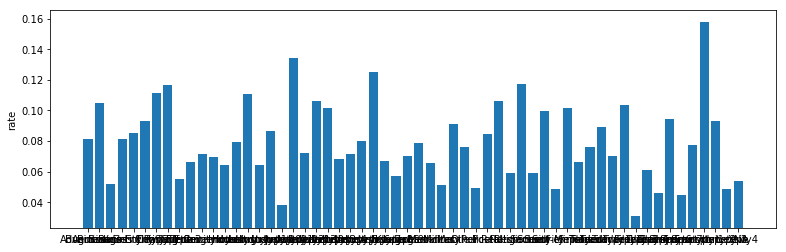

In [40]:
org_df = category_information(data_train, 'ORGANIZATION_TYPE')

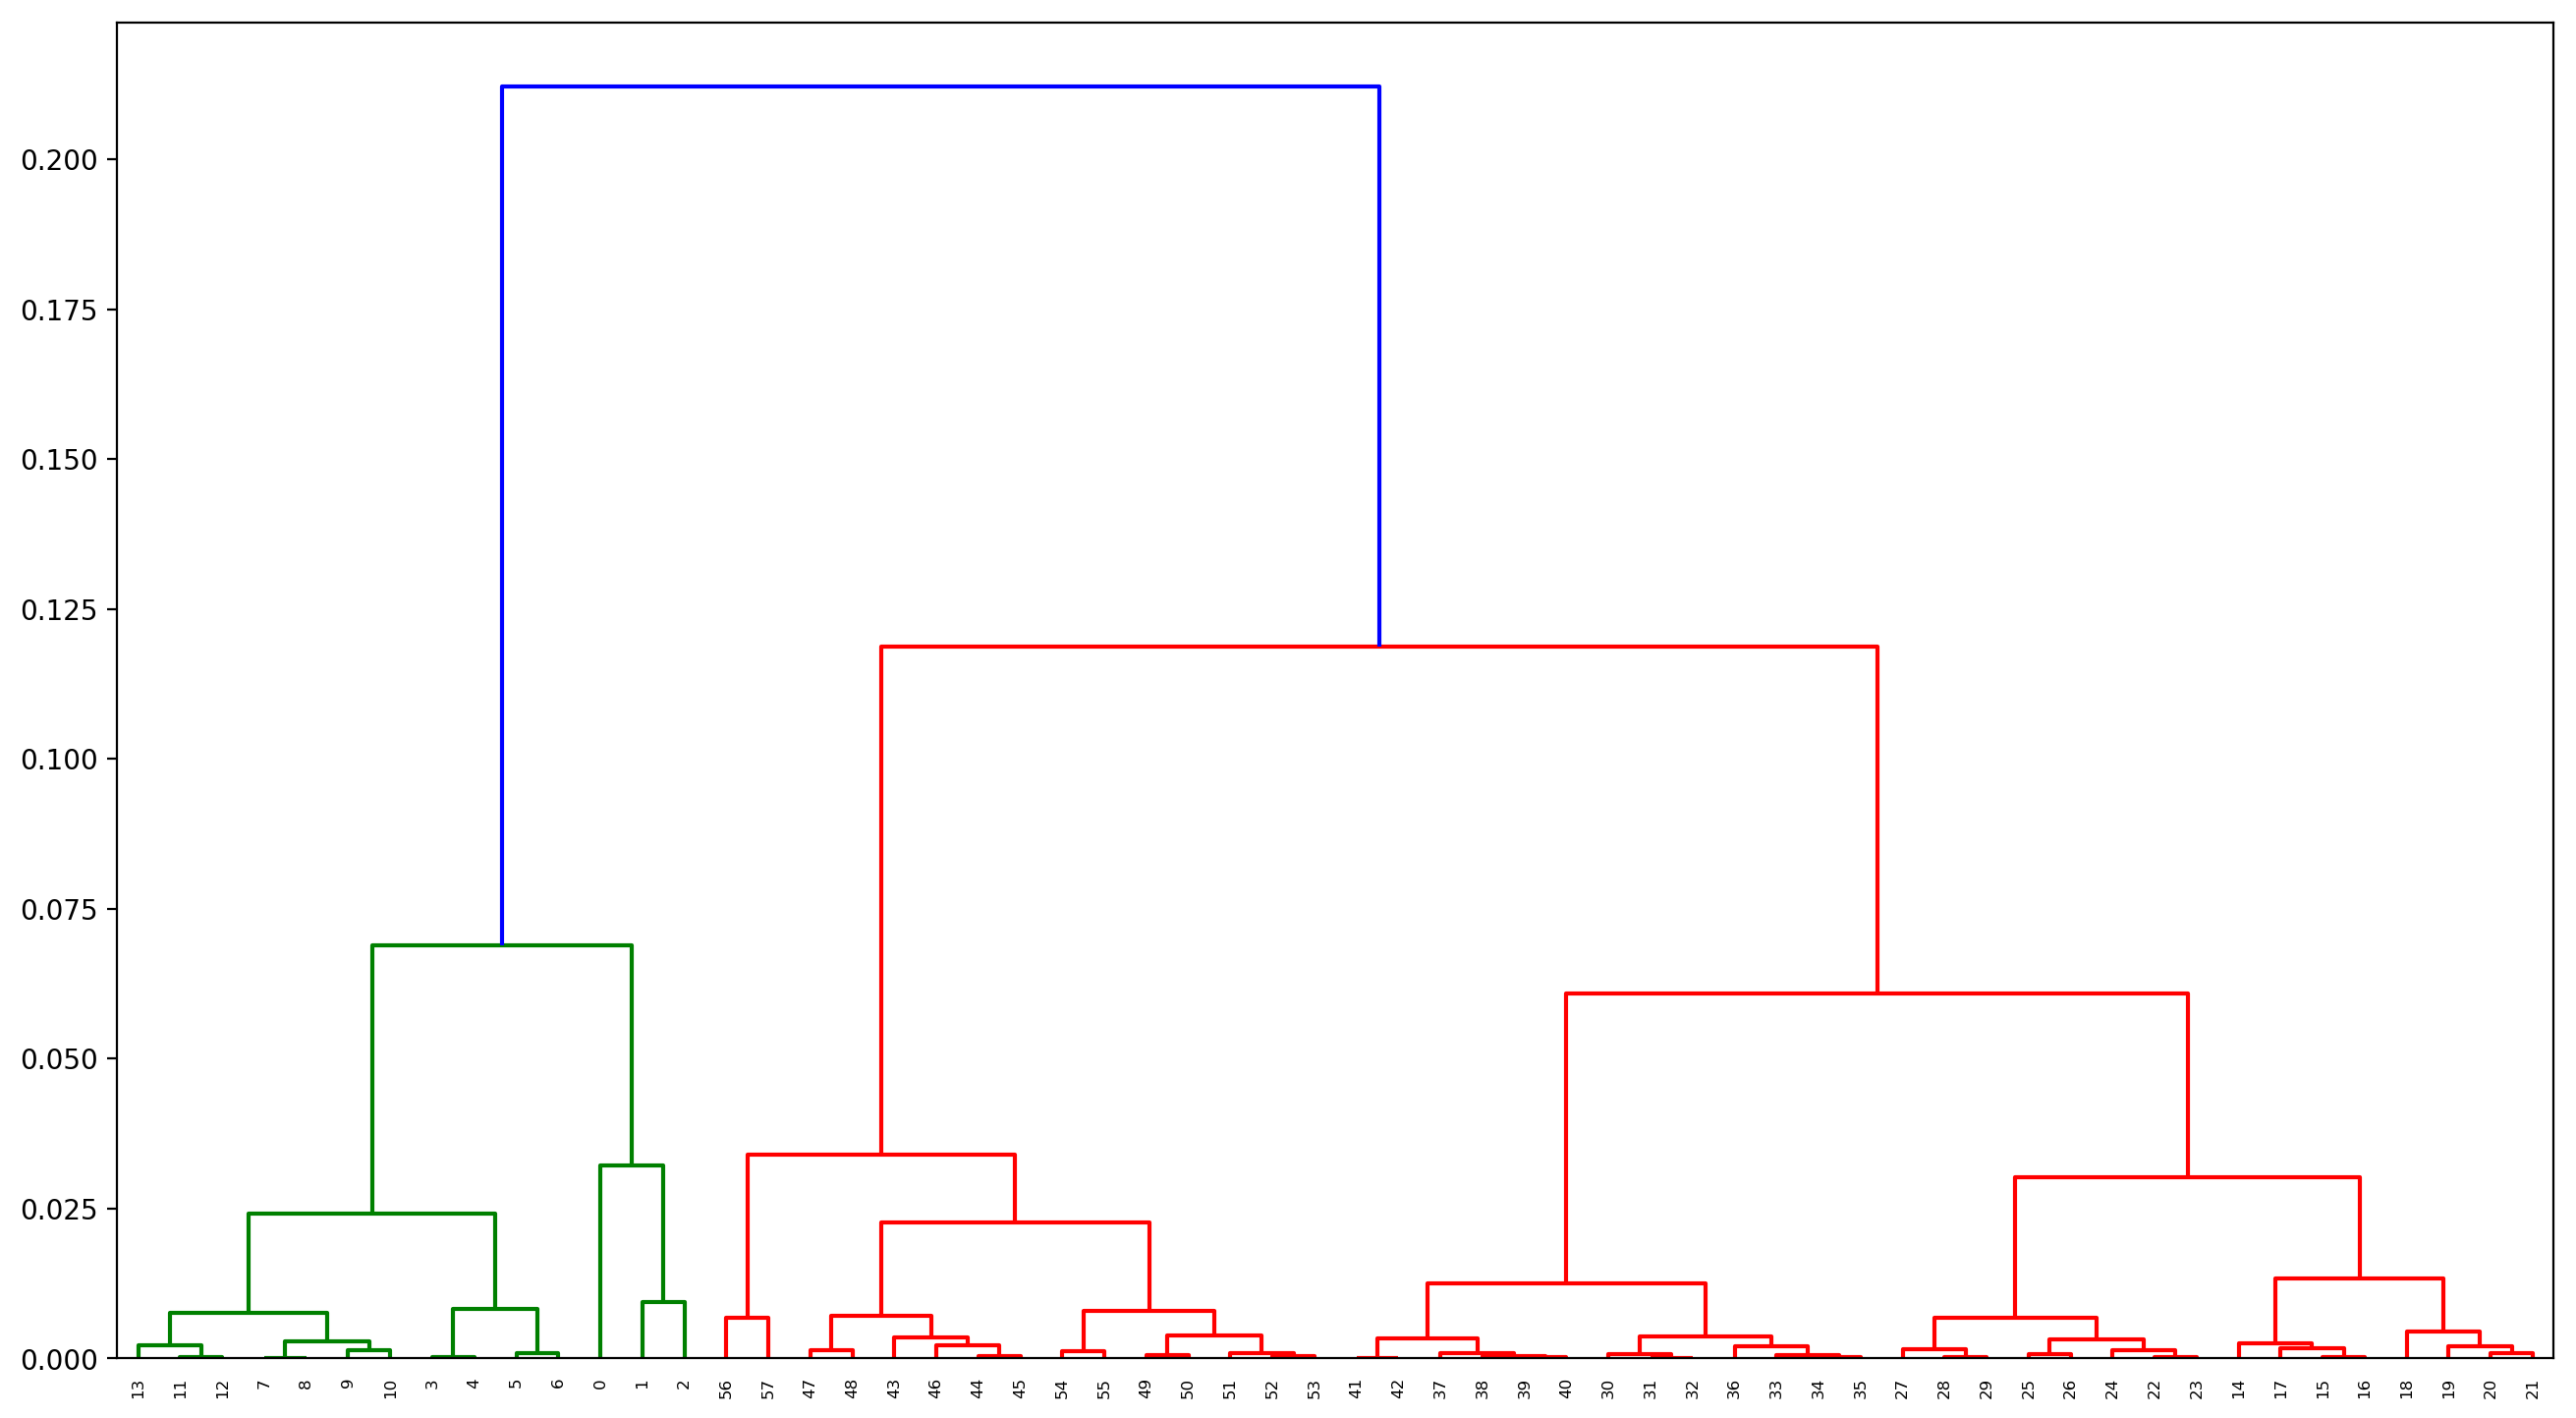

array([ 4,  3,  3,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1, 11, 11, 11,
       11, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,
        9,  9,  9,  8,  8,  8,  8,  8,  8,  6,  6,  6,  6,  6,  6,  7,  7,
        7,  7,  7,  7,  7,  5,  5], dtype=int32)

In [47]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
linkage_result = linkage(org_df[['rate']], method='ward', metric='euclidean')
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result)
plt.show()
fcluster(linkage_result, 0.01, criterion='distance')

In [65]:
org_df['class'] = fcluster(linkage_result, 0.01, criterion='distance')

b_c = np.nan
num = 0
new_class = []
for k, c in enumerate(org_df['class']):
    if c == b_c:
        b_c = c
    else:
        num = num + 1
        b_c = c
    new_class.append(num)
org_df['n_class'] = new_class
org_df.head(5)

,rate,element,length,class,n_class
0,0.157540,Transport: type 3,1187,4,1
1,0.134328,Industry: type 13,67,3,2
2,0.125000,Industry: type 8,24,3,2
3,0.117062,Restaurant,1811,2,3
4,0.116798,Construction,6721,2,3


In [68]:
cam = data_train['ORGANIZATION_TYPE'][0]
[org_df[org_df['element'] == cam].n_class.values[0] for cam in data_train['ORGANIZATION_TYPE']]


[5,
 10,
 8,
 5,
 10,
 7,
 5,
 7,
 10,
 9,
 9,
 10,
 6,
 4,
 7,
 6,
 8,
 3,
 7,
 8,
 4,
 5,
 4,
 10,
 5,
 5,
 5,
 6,
 11,
 5,
 5,
 9,
 6,
 4,
 11,
 4,
 7,
 5,
 10,
 5,
 5,
 3,
 4,
 10,
 5,
 4,
 10,
 5,
 8,
 7,
 10,
 9,
 8,
 4,
 10,
 9,
 10,
 4,
 5,
 5,
 6,
 8,
 10,
 11,
 1,
 11,
 8,
 3,
 8,
 7,
 5,
 5,
 5,
 7,
 4,
 4,
 10,
 4,
 6,
 10,
 5,
 10,
 5,
 1,
 10,
 6,
 7,
 5,
 10,
 5,
 8,
 5,
 7,
 5,
 4,
 4,
 3,
 5,
 8,
 10,
 9,
 8,
 6,
 7,
 9,
 10,
 10,
 5,
 10,
 7,
 8,
 7,
 6,
 8,
 9,
 5,
 5,
 10,
 10,
 5,
 5,
 7,
 8,
 4,
 4,
 10,
 5,
 7,
 4,
 5,
 4,
 3,
 4,
 3,
 9,
 5,
 10,
 5,
 5,
 4,
 10,
 7,
 4,
 10,
 8,
 9,
 8,
 4,
 7,
 8,
 4,
 4,
 5,
 5,
 5,
 8,
 10,
 10,
 10,
 10,
 5,
 8,
 6,
 4,
 7,
 4,
 4,
 3,
 4,
 4,
 4,
 5,
 8,
 10,
 10,
 10,
 7,
 5,
 8,
 4,
 3,
 10,
 7,
 4,
 5,
 10,
 5,
 4,
 5,
 5,
 4,
 11,
 5,
 4,
 4,
 4,
 6,
 9,
 4,
 4,
 5,
 9,
 11,
 6,
 4,
 5,
 5,
 7,
 5,
 5,
 9,
 4,
 7,
 10,
 4,
 5,
 7,
 4,
 5,
 5,
 10,
 3,
 10,
 8,
 6,
 6,
 10,
 10,
 4,
 5,
 5,
 5,
 5,
 10,
 6,
 7,
 4,
 10,

In [42]:
test_train_collection(data_train, data_test, 'ORGANIZATION_TYPE')

====Test columns====
Kindergarten
6880 1038
Self-employed
38411 5920
Transport: type 3
1187 174
Business Entity Type 3
67992 10840
Government
10404 1508
Industry: type 9
3368 499
School
8893 1287
Trade: type 2
1900 242
XNA
55374 9274
Services
1575 302
Bank
2506 374
Industry: type 3
3278 489
Other
16683 2707
Trade: type 6
631 122
Industry: type 12
369 77
Trade: type 7
7831 1303
Postal
2157 294
Medicine
11193 1716
Housing
2958 435
Business Entity Type 2
10552 1479
Construction
6721 1039
Military
2634 530
Industry: type 4
877 167
Trade: type 3
3492 578
Legal Services
305 53
Security
3247 472
Industry: type 11
2704 416
University
1327 221
Business Entity Type 1
5983 887
Agriculture
2454 292
Security Ministries
1974 341
Transport: type 2
2203 448
Industry: type 7
1307 217
Transport: type 4
5398 884
Telecom
577 95
Emergency
560 91
Police
2340 441
Industry: type 1
1039 178
Transport: type 1
201 35
Electricity
950 156
Industry: type 5
599 97
Hotel
966 134
Restaurant
1811 284
Advertising
429 71

### FONDKAPREMMONT_MODE

FONDKAPREMONT_MODE


,rate,element,length
1,0.086188,nan,210295
4,0.075435,not specified,5687
0,0.069782,reg oper account,73830
3,0.065563,reg oper spec account,12080
2,0.058195,org spec account,5619


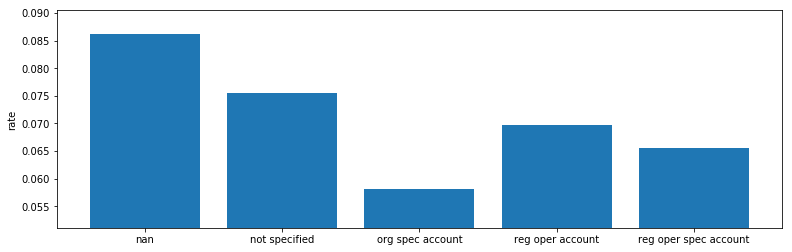

In [120]:
category_information(data_train, 'FONDKAPREMONT_MODE')

In [174]:
test_train_collection(data_train, data_test, 'FONDKAPREMONT_MODE')

====Test columns====
nan
210295 32797
reg oper account
73830 12124
not specified
5687 913
org spec account
5619 920
reg oper spec account
12080 1990
====Needless train columns====


In [71]:
data_train['FONDKAPREMONT_MODE'] = (data_train['FONDKAPREMONT_MODE'].replace('not specified', 2)
                                    .replace('reg oper spec account', 1)
                                    .replace('reg oper account', 1).replace('org spec account', 0)
                                   )

In [72]:
data_train['FONDKAPREMONT_MODE'].sum()

97281.0

### HOUSETYPE_MODE

HOUSETYPE_MODE


,rate,element,length
3,0.101401,specific housing,1499
1,0.091512,nan,154297
2,0.084983,terraced house,1212
0,0.069434,block of flats,150503


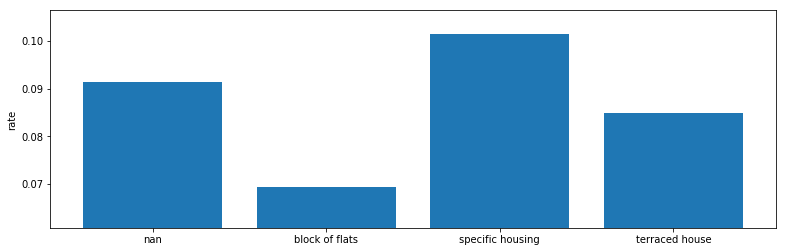

In [121]:
category_information(data_train, 'HOUSETYPE_MODE')

In [175]:
test_train_collection(data_train, data_test, 'HOUSETYPE_MODE')

====Test columns====
block of flats
150503 24659
nan
154297 23619
specific housing
1499 262
terraced house
1212 204
====Needless train columns====


In [74]:
data_train['HOUSETYPE_MODE'] = (data_train['HOUSETYPE_MODE'].replace('specific housing', 1)
                                .replace('terraced house', 1).replace('block of flats', 0))

In [75]:
data_train['HOUSETYPE_MODE'].sum()

2711.0

### EMERGENCYSTATE_MODE

EMERGENCYSTATE_MODE


,rate,element,length
2,0.095790,Yes,2328
1,0.092607,nan,145755
0,0.069649,No,159428


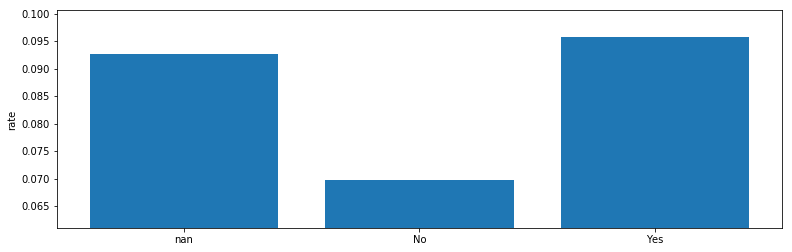

In [122]:
category_information(data_train, 'EMERGENCYSTATE_MODE')

In [176]:
test_train_collection(data_train, data_test, 'EMERGENCYSTATE_MODE')

====Test columns====
No
159428 26179
nan
145755 22209
Yes
2328 356
====Needless train columns====


In [119]:
data_train['HOUSETYPE_MODE']

0         0.0
1         0.0
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
11        NaN
12        0.0
13        0.0
14        0.0
15        NaN
16        NaN
17        NaN
18        0.0
19        NaN
20        0.0
21        NaN
22        0.0
23        0.0
24        0.0
25        0.0
26        0.0
27        NaN
28        NaN
29        0.0
         ... 
307481    NaN
307482    0.0
307483    0.0
307484    NaN
307485    NaN
307486    0.0
307487    NaN
307488    NaN
307489    0.0
307490    NaN
307491    NaN
307492    NaN
307493    NaN
307494    NaN
307495    0.0
307496    NaN
307497    NaN
307498    0.0
307499    NaN
307500    0.0
307501    0.0
307502    NaN
307503    NaN
307504    NaN
307505    0.0
307506    0.0
307507    0.0
307508    0.0
307509    0.0
307510    0.0
Name: HOUSETYPE_MODE, Length: 307504, dtype: float64

In [122]:
def one_hot_encoding(data, column, drop_first):
    dataset = data.copy()
    add_df = pd.get_dummies(dataset[column], drop_first)
    new_col = [column + '_' + str(col) for col in add_df.columns]
    add_df.columns = new_col
    print(new_col)
    del dataset[column]
    return pd.concat([dataset, add_df], axis=1)

In [127]:
one_hot_encoding(data_train, 'EMERGENCYSTATE_MODE', True)['EMERGENCYSTATE_MODE_True_Yes']


['EMERGENCYSTATE_MODE_True_No', 'EMERGENCYSTATE_MODE_True_Yes']


0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        1
27        0
28        0
29        0
         ..
307481    0
307482    0
307483    0
307484    0
307485    0
307486    0
307487    0
307488    0
307489    1
307490    0
307491    0
307492    0
307493    0
307494    0
307495    0
307496    0
307497    0
307498    0
307499    0
307500    0
307501    0
307502    0
307503    0
307504    0
307505    0
307506    0
307507    0
307508    0
307509    0
307510    0
Name: EMERGENCYSTATE_MODE_True_Yes, Length: 307504, dtype: uint8